## Set up

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.init import kaiming_uniform_, xavier_uniform_

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_curve

## Abstract classes for custom datasets, main classifier and early stopping


In [3]:
class TrainDataset(Dataset):
    """An abstract class representing the training dataset"""
    def __init__(self, X, y):
        """
        Args:
        X (dataframe): set of predictors
        y (series): corresponding target variable 
        """
        self.X = X.astype('float32')
        self.y = y.astype('float32').values.reshape((len(y), 1))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

class TestDataset(Dataset):
    """An abstract class representing the unseen test dataset"""
    def __init__(self, X):
        """
        Args:
            X (dataframe): set of predictors
        """
        self.X = X.astype('float32')

    def __getitem__(self, idx):
        return self.X[idx]
            
    def __len__(self):
        return len(self.X)

class BinaryClassifier(nn.Module):
    """A multilayer perceptron designed for binary classification problems"""
    def __init__(self, n_inputs, n_hidden, n_outputs):
        """
        Args:
        n_inputs (int): number of features in training set
        n_hidden (int): number of nodes in hidden layers
        n_outputs (int): number of outputs (e.g.: 1 for binary classification)
        """
        super(BinaryClassifier, self).__init__()

        # the combination of Relu activation and He Uniform weight initialization comes 
        # a lonng way to overcome the problem of vanishing gradients when training 
        # deep neural network models
        self.h1 = nn.Linear(n_inputs, n_hidden)
        kaiming_uniform_(self.h1.weight, nonlinearity='relu')
        self.a1 = nn.ReLU()
        self.b1 = nn.BatchNorm1d(n_hidden)

        self.h2 = nn.Linear(n_hidden, n_hidden)
        kaiming_uniform_(self.h2.weight, nonlinearity='relu')
        self.a2 = nn.ReLU()
        self.d2 = nn.Dropout(p=0.1)

        self.h3 = nn.Linear(n_hidden, n_outputs)
        xavier_uniform_(self.h3.weight)
        self.a3 = nn.Sigmoid()

    def forward(self, inp):
        out = self.a1(self.h1(inp))
        out = self.b1(out)
        out = self.a2(self.h2(out))
        out = self.d2(out)
        out = self.a3(self.h3(out))
        return out

class EarlyStopping():
    """Early stops the training if validation loss doesn't improve after a given patience"""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): how long to wait after last time validation loss improved.
                            default: 7
            verbose (bool): if True, print a message for each validation loss improvement. 
                            default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, checkpoint):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, checkpoint)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, checkpoint)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, checkpoint):
        """Save model when validation loss decreases"""
        if self.verbose:
            print(f'Val loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), model_save_path)
        torch.save(checkpoint, checkpoint_save_path)
        self.val_loss_min = val_loss

## Utility functions to prepare datasets, train and evaluate model, infer predictions and more

In [4]:
def prepare_train_data(path, batch_size, val_size, does_scale=True):
    """
    Split data into train and validation sets, scale them approriately and 
    convert them into DataLoader iterators
        :param path (string): file location of the training data set
        :param batch_size (int): batch size for data loader
        :param val_size (float): proportion of data set to include in validation split
        :param does_scale (bool): whether to normalize the data or not
        :return: train data loader (iterator), validation data loader (iterator), 
                training set of predictors (dataframe), training set of target variable (series),
                validation set of predictors (dataframe), validation set of target variable (series),
                scaler based on training data (estimator)
    """
    data = pd.read_pickle(path)
    X = data.drop('label', axis=1)
    y = data['label']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=42)

    # when using a neural network, it’s advisable to normalize numeric predictors 
    # so that values with large magnitudes don’t overwhelm small values; plus, we 
    # should normalize val data using the training set values 
    if does_scale: 
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)
    else:
        scaler = None

    train_ds = TrainDataset(X_train, y_train)
    val_ds = TrainDataset(X_val, y_val)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return train_dl, val_dl, X_train, X_val, y_train, y_val, scaler


def prepare_test_data(path, scaler):
    """
    Scale unseen data according to training set (if specified) and convert it into
    a data loader to be fed into the network later
        :param path (string): file location of the unseen test data
        :param scaler (estimator): either None or the normalizer based on training values
    """
    X = pd.read_pickle(path)

    if scaler:
        X_test = scaler.transform(X)
    test_ds = TestDataset(X_test)
    test_dl = DataLoader(test_ds, batch_size=1)
    
    return test_dl

In [5]:
def train_model(model, optimizer, loss_fn, train_dl):
    """
    Model training with backpropogation
        :param model (nn.Module): pre-defined model
        :param optimizer (nn.optim): pre-defined optimizer
        :param loss_fn: criterion/metrics to optimize on 
        :param train_dl (iterator): data loader of training set
        :return: epoch loss (float)
    """
    model.train()

    epoch_loss = 0
    for inputs, targets in train_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        preds = model(inputs)
        loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(train_dl)


def evaluate_model(model, loss_fn, val_dl):
    """
    Evaluate model on data that wasn't used for training without backprogation
    :param model (nn.Module): pre-defined model
    :param loss_fn: criterion used for to optimze on 
    :param val_dl (iterator): data loader of validation/test set
    :return: epoch loss (float)  
    """
    model.eval()

    epoch_loss = 0
    with torch.no_grad():
        for inputs, targets in val_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model(inputs)
            loss = loss_fn(preds, targets)
            assert loss.requires_grad is False

            epoch_loss += loss.item()

    return epoch_loss / len(val_dl)


def infer_preds(model, dl, is_train=False):
    """
    Infer probability estimates of positive class 
        :param model (nn.Module): trained model
        :param dl (iterator): data loader of the dataset to be inferred
        :param is_train (bool): whether this data has been used for training 
        :return: predicted values (list)
    """
    pred_ls = []
    model.eval()

    with torch.no_grad():
        if not is_train:
            for inputs in dl: 
                inputs = inputs.to(device)
                preds = model(inputs)
                pred_ls.append(preds.cpu().numpy())
            pred_ls = [i.squeeze().tolist() for i in pred_ls]
        else:
            for inputs, _ in dl:
                inputs = inputs.to(device)
                preds = model(inputs)
                pred_ls = np.append(pred_ls, preds.cpu().numpy())
    
    return pred_ls


def process_loop(n_epochs, model, optimizer, loss_fn, train_dl, val_dl):
    """
    Run entire training loop which comprises of multiple epochs
        :param n_epochs (int): number of maximum epochs to train through
        :param model (nn.Module): pre-defined model
        :param optimizer (nn.optim): pre-defined optimizer
        :param loss_fn: criterion for optimizer to iterate on
        :param train_dl (iterator): training data loader
        :param val_dl (iterator): validation data loader
        :return: train losses of all epochs (list of floats), 
                validation losses of all epochs (list of floats)
    """
    early_stopping = EarlyStopping(patience=7, verbose=True)

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        start_time = time.time()

        train_loss = train_model(model, optimizer, loss_fn, train_dl)
        val_loss = evaluate_model(model, loss_fn, val_dl)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': round(train_loss, 5),
            'val_loss': round(val_loss, 5)
        }

        early_stopping(val_loss, model, checkpoint)
        if early_stopping.early_stop:
            print('Early stopping')
            break
        
        print('Epoch: {} | Time: {}m {}s'.format(epoch, epoch_mins, epoch_secs))
        print('\tTrain loss: {}'.format(round(train_loss, 5)))
        print('\tVal loss: {}'.format(round(val_loss, 5)))

    return train_losses, val_losses

In [6]:
def count_parameters(model):
    """Count the number of trainable parameters in the model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def epoch_time(start_time, end_time):
    """Calculate time to train each epoch"""
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def load_checkpoint(model, opt, path):
    """Load model from its most recent checkpoint. Note that input model 
    & optimizer should be pre-defined.  This routine only updates their states.
        :param model (nn.Module): pre-defined model 
        :param opt (nn.optim): pre-defined optimizer
        :param path (string): where the checkpoint was saved
        :return: updated model (nn.Module), updated optimizer (nn.optim), 
                epoch number where training was left off (int), training loss (float),
                validation loss (float)
    """
    start_epoch = 0
    if os.path.isfile(path):
        print("=> loading checkpoint '{}'".format(path))
        checkpoint = torch.load(path)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['model_state_dict'])
        opt.load_state_dict(checkpoint['optimizer_state_dict'])
        train_loss = checkpoint['train_loss']
        val_loss = checkpoint['val_loss']
        print("=> loaded checkpoint '{}' (epoch {})"
                .format(path, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(path))

    return model, opt, start_epoch, train_loss, val_loss

In [7]:
def get_youden_thres(y_true, y_prob):
    """
    Compute the threshold that separates postive and negative classes based on Youden's J statistic.
    J = sensitivity + specificity - 1 = TPR + (1 - FPR) - 1 = TPR - FPR.
      :param y_true: true labels
      :param y_prob: probability estimates of positive class
      :return: separating threshold based on Youden's index
    """
    fpr, tpr, thres = roc_curve(y_true, y_prob)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'fpr': pd.Series(fpr, index=i),
                        'tpr': pd.Series(tpr, index=i),
                        '1-fpr': pd.Series(1 - fpr, index=i),
                        'youden': pd.Series(tpr - fpr, index=i),
                        'threshold': pd.Series(thres, index=i)})
    opt_pt = roc.iloc[roc['youden'].idxmax(), :]
    return opt_pt['threshold']

## Training process

In [8]:
train_path = '/content/gdrive/My Drive/KalapaCreditScoringChallenge/data/intermediate/train2.pkl'
save_dir = '/content/gdrive/My Drive/KalapaCreditScoringChallenge/models'
model_save_path = os.path.join(save_dir, 'MLP.pt')
checkpoint_save_path = os.path.join(save_dir, 'MLP-checkpoint.tar')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_outputs = 1  # binary classification

# hyperparameters that should be selected through trials and errors
N_EPOCHS = 100 
BATCH_SIZE = 128
N_HIDDEN = 50
LEARNING_RATE = 0.01

In [9]:
train_dl, val_dl, X_train, X_val, y_train, y_val, scaler = prepare_train_data(train_path, 
                                                                              BATCH_SIZE, 
                                                                              0.20)

n_inputs = X_train.shape[1]
model = BinaryClassifier(n_inputs, N_HIDDEN, n_outputs)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
print('The model has {} trainable parameters'.format(count_parameters(model)))

The model has 12001 trainable parameters


In [10]:
train_losses, val_losses = process_loop(n_epochs=N_EPOCHS, 
                                       optimizer=optimizer,
                                       model=model, 
                                       loss_fn=nn.BCELoss(),
                                       train_dl=train_dl,
                                       val_dl=val_dl)

Val loss decreased (inf --> 0.618667).  Saving model ...
Epoch: 0 | Time: 0m 0s
	Train loss: 0.66639
	Val loss: 0.61867
Val loss decreased (0.618667 --> 0.604297).  Saving model ...
Epoch: 1 | Time: 0m 0s
	Train loss: 0.62376
	Val loss: 0.6043
Val loss decreased (0.604297 --> 0.596213).  Saving model ...
Epoch: 2 | Time: 0m 0s
	Train loss: 0.60766
	Val loss: 0.59621
Val loss decreased (0.596213 --> 0.591124).  Saving model ...
Epoch: 3 | Time: 0m 0s
	Train loss: 0.6007
	Val loss: 0.59112
Val loss decreased (0.591124 --> 0.587887).  Saving model ...
Epoch: 4 | Time: 0m 0s
	Train loss: 0.59435
	Val loss: 0.58789
Val loss decreased (0.587887 --> 0.584306).  Saving model ...
Epoch: 5 | Time: 0m 0s
	Train loss: 0.58882
	Val loss: 0.58431
Val loss decreased (0.584306 --> 0.582414).  Saving model ...
Epoch: 6 | Time: 0m 0s
	Train loss: 0.5872
	Val loss: 0.58241
Val loss decreased (0.582414 --> 0.580087).  Saving model ...
Epoch: 7 | Time: 0m 0s
	Train loss: 0.58325
	Val loss: 0.58009
Val loss

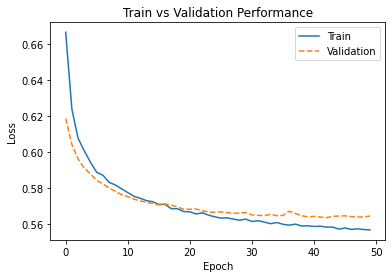

In [11]:
plt.plot(train_losses, marker='', label='Train')
plt.plot(val_losses, linestyle='dashed', label='Validation')
plt.title('Train vs Validation Performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

## Inference process

In [12]:
save_dir = '/content/gdrive/My Drive/KalapaCreditScoringChallenge/results'
X_test_path = '/content/gdrive/My Drive/KalapaCreditScoringChallenge/data/intermediate/test1.pkl'
test_ids = pd.read_csv('/content/gdrive/My Drive/KalapaCreditScoringChallenge/data/raw/test.csv', low_memory=False)['id']

test_dl = prepare_test_data(X_test_path, scaler)
test_preds = infer_preds(model, test_dl)

In [13]:
submission_df_binary = pd.concat([test_ids, 
                                  pd.DataFrame(np.rint(test_preds), columns=['label'])], 
                                 axis=1)
submission_df_binary.to_csv(os.path.join(save_dir, 'MLP_binary.csv'), index=False)

In [14]:
train_preds = infer_preds(model, train_dl, is_train=True)
train_youden_thres = get_youden_thres(y_train.astype('category'), train_preds)
test_youden_binary = np.where(test_preds >= train_youden_thres, 1, 0)

submission_df_youden = pd.concat([test_ids, 
                                  pd.DataFrame(test_youden_binary, columns=['label'])], 
                                 axis=1)
submission_df_youden.to_csv(os.path.join(save_dir, 'MLP_youden.csv'), index=False)